# CS 440 Final - NLBSE'25

## Dependencies
This cell contains the download for dependancies used in this notebook. Specifically setfit and transformers, making sure the transformers version installed are compatible with pytorth. Aswell this cell creats a directory for where our trained models are stored.

Setfit is a framework we're using (which the baseline also used) to provide us high accuracy with pre-trained models.

We use transformers version 4.42.2 since the version of pytorch wouldn't be comptaible without reducing it to this version.

In [ ]:
!pip install setfit==1.1.0
!mkdir models
!pip install transformers==4.42.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.2/75.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     

## Imported Libraries
This cell imports all needed libraries for future data processing, model training and other required frameworks to help train, evaluate, and present our findings. It's important to note the import of SetFitModel and SetFitTrainer which is used in the original benchmark notebook.

In [ ]:
import pandas as pd
import time
from setfit import SetFitModel, SetFitTrainer
from datasets import Dataset, DatasetDict, load_dataset
from tqdm.auto import tqdm
import numpy as np
import torch
import re
from datasets import load_dataset

tqdm.pandas()

## Data Preprocessing
Due to the data being preprocessed we decided to not do much preprocessing due to the extent the data was already preprocessed.

The only proprocessing we did was make sure the comment sizes didn't exceed a maximum of 512 characters. *italicized text*

In [ ]:
# dataset from hf_hub
langs = ['java', 'python', 'pharo']
labels = {
    'java': ['summary', 'Ownership', 'Expand', 'usage', 'Pointer', 'deprecation', 'rational'],
    'python': ['Usage', 'Parameters', 'DevelopmentNotes', 'Expand', 'Summary'],
    'pharo': ['Keyimplementationpoints', 'Example', 'Responsibilities', 'Classreferences', 'Intent', 'Keymessages', 'Collaborators']
}
ds = load_dataset('NLBSE/nlbse25-code-comment-classification')
ds

for lan in langs:
   training_data = ds[f'{lan}_train']

   new_comments_list = []

   for comment in training_data:
     new_comment = comment['combo']
     new_comment = new_comment[:512]

     new_comments_list.append(new_comment)

   ds[f'{lan}_train'] = ds[f'{lan}_train'].remove_columns(['combo'])
   ds[f'{lan}_train'] = ds[f'{lan}_train'].add_column('combo', new_comments_list)

## Model Training

In this coding cell, this is where we are training the pretrained models we got from the SetFit framework. It's important to note that we took a similar apporach with our models as the benchmark.

The model we decided to take was paraphrase-TinyBERT-L6-v2 due to it's high accuracy and low computational costs compared to MiniLM. This allowed for us to train the models with better tuned hyper parameters (number of epochs, batch sie, learning_rate, etc) to allow for a better trained model with not much computational overhead compared to MiniLM (baseline model).

For the languages pharo and python, we decided to actually change the hyper parameters to reduce overfitting. Since pharo and python are more generic of a language as Java, and there's less data compared to python and java, this lead to overfitting so we reduced some hyper parameters to combat this.

In [ ]:
for lan in langs:
    # Models for Java and Python
    if lan == 'java':
      model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-TinyBERT-L6-v2", multi_target_strategy="multi-output", device='cuda')
      trainer = SetFitTrainer(
          model=model,
          train_dataset=ds[f'{lan}_train'],
          column_mapping={"combo": "text", "labels": "label"},
          num_epochs=2,
          batch_size=64,
          learning_rate=3e-5,
          num_iterations=10,
          warmup_proportion=0.05,
          use_amp=True,
      )
      trainer.train()
      trainer.model.save_pretrained(f'./models/{lan}')

    # Model for Pharo
    if lan == "pharo" or lan == 'python':
      model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-TinyBERT-L6-v2", multi_target_strategy="multi-output", device='cuda')
      trainer = SetFitTrainer(
          model=model,
          train_dataset=ds[f'{lan}_train'],
          column_mapping={"combo": "text", "labels": "label"},
          num_epochs=2,
          batch_size=32,
          num_iterations=30,
          warmup_proportion=0.05,
          use_amp=True,
      )
      trainer.train()
      trainer.model.save_pretrained(f'./models/{lan}')

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
<ipython-input-7-0c0a0de8c9e0>:5: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(
Applying column mapping to the training dataset
***** Running training *****
  Num unique pairs = 152280
  Batch size = 64
  Num epochs = 2
/usr/local/lib/python3.10/dist-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
1,0.309300
50,0.251900
100,0.160700
150,0.117800
200,0.092800
250,0.078800
300,0.068400
350,0.056600
400,0.057300
450,0.046900


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

KeyboardInterrupt: 

## Evaluation
For evaluating our models performance, we decided to use the same measurments as the baseline notebook to depect an accurate comparison between our results and the baseline results.

We found that overall, our model performed better in precision, recall, and overall f1 scores compare to the baseline models. Below is the table depicting our statistics associated with each label of each language. If both tables are compared side by side, overall our models out performed in all categories.

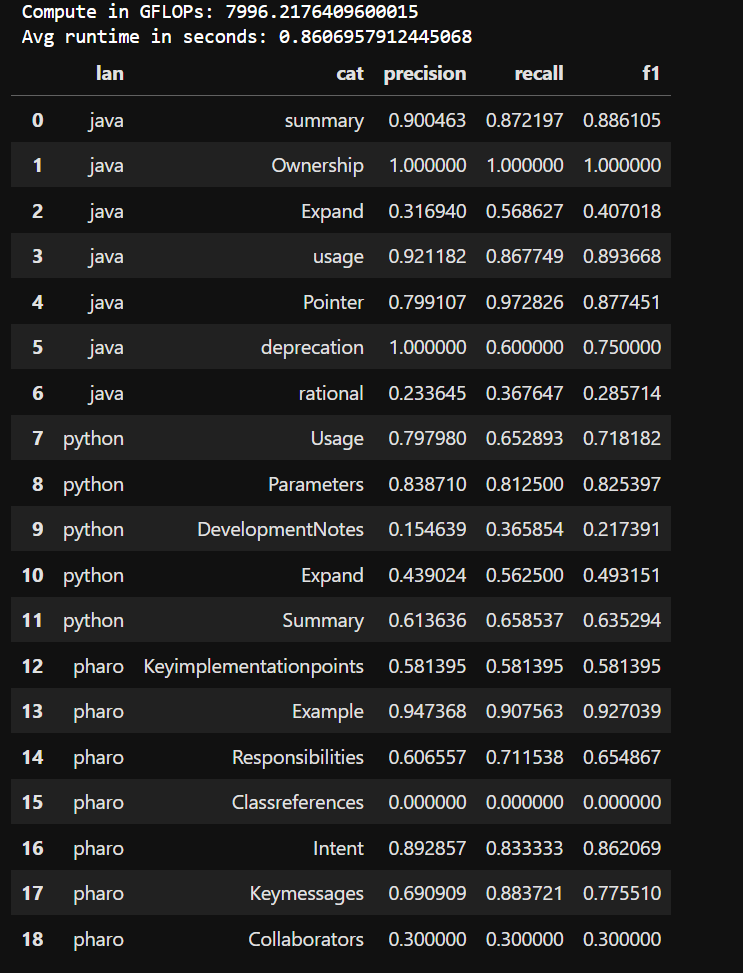

In [ ]:
total_flops = 0
total_time = 0
scores = []
for lan in langs:
    # to load trained models:
    model = SetFitModel.from_pretrained(f'./models/{lan}')
    # to load pretrained models from Hub:
    with torch.profiler.profile(with_flops=True) as p:
        begin = time.time()
        for i in range(10):
          y_pred = model(ds[f'{lan}_test']['combo']).numpy().T
        total = time.time() - begin
        total_time = total_time + total
    total_flops = total_flops + (sum(k.flops for k in p.key_averages()) / 1e9)
    y_true = np.array(ds[f'{lan}_test']['labels']).T
    for i in range(len(y_pred)):
        assert(len(y_pred[i]) == len(y_true[i]))
        tp = sum([true == pred == 1 for (true,pred) in zip(y_true[i], y_pred[i])])
        tn = sum([true == pred == 0 for (true,pred) in zip(y_true[i], y_pred[i])])
        fp = sum([true == 0 and pred == 1 for (true,pred) in zip(y_true[i], y_pred[i])])
        fn = sum([true == 1 and pred == 0 for (true,pred) in zip(y_true[i], y_pred[i])])
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2*tp) / (2*tp + fp + fn)
        scores.append({'lan': lan, 'cat': labels[lan][i],'precision': precision,'recall': recall,'f1': f1})
print("Compute in GFLOPs:", total_flops/10)
print("Avg runtime in seconds:", total_time/10)
scores = pd.DataFrame(scores)
scores

NameError: name 'langs' is not defined

In [ ]:
max_avg_runtime = 5
max_avg_flops = 5000

# s𝑢𝑏𝑚𝑖𝑠𝑠𝑖𝑜𝑛_𝑠𝑐𝑜𝑟𝑒(𝑚𝑜𝑑𝑒𝑙)=(𝑎𝑣𝑔. 𝐹1)×0.60+((𝑚𝑎𝑥_𝑎𝑣𝑔_𝑟𝑢𝑛𝑡𝑖𝑚𝑒−𝑚𝑒𝑎𝑠𝑢𝑟𝑒𝑑_𝑎𝑣𝑔_𝑟𝑢𝑛𝑡𝑖𝑚𝑒)/𝑚𝑎𝑥_𝑎𝑣𝑔_𝑟𝑢𝑛𝑡𝑖𝑚𝑒)×0.2+((𝑚𝑎𝑥_GFLOPs−𝑚𝑒𝑎𝑠𝑢𝑟𝑒𝑑_GFLOPs)/𝑚𝑎𝑥_GFLOPs)×0.2
def score(avg_f1, avg_runtime, avg_flops):
    return (0.6 * avg_f1 +
      0.2 * ((max_avg_runtime - avg_runtime) / max_avg_runtime) +
      0.2 * ((max_avg_flops - avg_flops) / max_avg_flops))

avg_f1 = scores.f1.mean()
avg_runtime = total_time/10
avg_flops = total_flops/10

round(score(avg_f1, avg_runtime, avg_flops), 2)